# PCA + Qstatistic (Square Prediction Error)による異常検知

PCA（主成分分析)で、多次元データを低次元空間に写像した後また元の次元に再写像を行う。

元データと再写像後の差分（残差）の2乗和をQ統計量や(Square Prediction Error:SPE)と呼び、これを異常度とした異常検知方法である。

以下数式で示す。

データセット$X_{n * n}$の主成分分析は、$X_{n * n}$の共分散行列$ \Sigma_{n * n} $の、固有値問題を解くことなので(解説は[^1])主成分$P_{n*n}$は次式で表せる。

\begin{equation}
(C_{n*n} - I_{n*n}\lambda)v_{n*1} = 0
\end{equation}

\begin{equation}
P_{n*n} = [v_1, v_2, ..., v_n]
\end{equation}

ここで$\lambda$は固有値、$v_i$は固有値である。

次元削減のために、寄与率（固有値の割合）の上位の主成分から累積寄与率85%～95%くらいの主成分（固有ベクトル）を使用する。

\begin{equation}
\sum_{i=1}^r\lambda_i \leq Percent * \sum_{i=1}^n\lambda_i
\end{equation}

得られた主成分で、部分空間にデータを写像する。

\begin{equation}
\{u\}_{1*r} = \{x_n\}_{1*n}[P]_{n*r}
\end{equation}


部分空間に写像されたデータに対して主成分行列の転置を掛けて元の空間に戻す。

\begin{equation}
\{E\}_{1*r} = \{x_n\}_{1*n} - \{u\}_{1*r}[P]_{n*r}^T 
\end{equation}

この残差を全てのデータに対して2乗して足したものがQ統計量、またはSquare Prediction Error:SPEとなる。

\begin{equation}
SPE = \sum_{i=1}^{n}(E_i)^2
\end{equation}

SPEの閾値決定方法は[^2]で議論されているらしいが、論文読めなかったので式だけ書いておく。

\begin{equation}
SPE_\alpha = \theta_1\left[\frac{c_\alpha\sqrt{2\theta_2h_0^2}}{\theta_1} + 1 + \frac{\theta_2h_0(h_0-1)}{\theta_1^2}\right]^{\frac{1}{h_0}}  
\end{equation}
\begin{equation}
\theta_i = \sum_{j=t+1}^{n}\lambda_{j}^{i}, \;\;for \;i=1,2,3
\end{equation}
\begin{equation}
h_0 = 1 - \frac{2\theta_1\theta_3}{3\theta_2^2}
\end{equation}
ここで$\theta_i$は、主成分として残さなかった固有ベクトルの$i$乗の和です。

次のセルで実装してみます。また$c_\alpha$は設定する信頼区間での正規分布のZscoreです。

[^1]: 京都大学 加納 学先生の解説 http://manabukano.brilliant-future.net/document/text-PCA.pdf

[^2]: J.E. Jackson, and G.S. Mudholkar, Control procedures for residuals associated with principal component analysis, Technometrics, pp. 331-349, 1979.

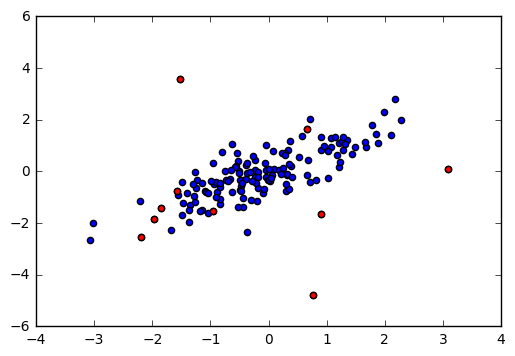

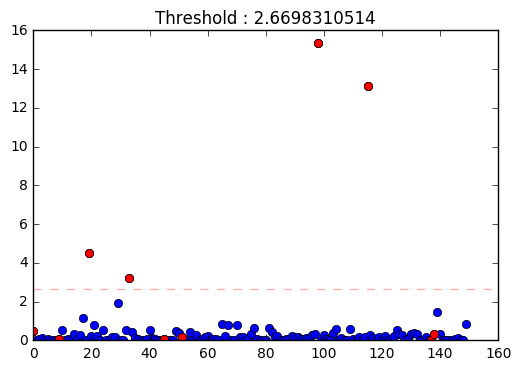

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_baseline = 150
n_outliers = 10
n_features = 2
n_comps = 1

# データの作成
gen_cov = np.eye(n_features)
gen_cov[1, 0] = 1.3

baseline_X = np.dot(np.random.randn(n_baseline, n_features), gen_cov)

# 異常値を含むデータの作成
outlier_cov = np.eye(n_features)
outlier_cov[np.arange(0, n_features), np.arange(0, n_features)] = 3.

outlier_X = np.dot(np.random.randn(n_baseline, n_features), gen_cov)
outlier_X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outlier_cov)
outlier_X_df = pd.DataFrame({
    'x1': outlier_X[:, 0],
    'x2': outlier_X[:, 1],
    'type': np.concatenate((np.zeros(n_baseline - n_outliers), np.ones(n_outliers)))
})
# シャッフル
outlier_X_df = outlier_X_df.reindex(
    np.random.permutation(outlier_X_df.index)
).reset_index(drop=True)
X = outlier_X_df[['x1', 'x2']].values
outlier_X = outlier_X_df[['x1', 'x2']].values

# データスケーリング(標準化)
scaler = StandardScaler()
baseline_X = scaler.fit_transform(baseline_X)
outlier_X = scaler.transform(outlier_X)

# 生データのプロット
plt.scatter(outlier_X[:, 0], outlier_X[:, 1])
plt.scatter(outlier_X[:, 0][outlier_X_df.type == 1], outlier_X[:, 1][outlier_X_df.type == 1], c='r')
plt.show()

# PCAで圧縮・再構築
pca = PCA(n_components=n_comps)
pca.fit(baseline_X)
outlier_X_encode = pca.transform(outlier_X)
outlier_X_decode = pca.inverse_transform(outlier_X_encode)
# SPEの算出
outlier_spe = np.sum(np.square(outlier_X - outlier_X_decode), axis=1)

# speの閾値決定
pca_origin = PCA(n_components=n_features)
pca_origin.fit(baseline_X)

# 残りの主成分数
remain_comps = n_features - n_comps

# 使っていない主成分λi
l = pca_origin.explained_variance_[-remain_comps:]

theta1 = np.sum(l)
theta2 = np.sum(l ** 2)
theta3 = np.sum(l ** 3)

# 閾値の算出
c_alpha = 3.25  # 99%信頼区間
h0 = 1 - ((2 * theta1 * theta3) / (3 * theta2 * theta2))
spe_th = theta1 * np.power((((c_alpha * np.sqrt((2 * theta2 * h0 * h0))) / theta1)
                            + 1 + ((theta2 * h0 * (h0 - 1)) / (theta1 * theta1))), 1/h0)

# SPEのプロット
plt.plot(np.arange(len(outlier_spe)), outlier_spe, 'o')
plt.plot(outlier_X_df[outlier_X_df.type == 1].index.values,
         outlier_spe[outlier_X_df[outlier_X_df.type == 1].index.values], 'o', color='r')
plt.axhline(y=spe_th, c='r', alpha=.3, ls='dashed')
plt.title('Threshold : ' + str(spe_th))
plt.show()
